# Pandana demo

Sam Maurer, July 2020

This notebook demonstrates the main features of the [Pandana](https://github.com/UDST/pandana/) library, a Python package for network analysis that uses [contraction hierarchies](https://en.wikipedia.org/wiki/Contraction_hierarchies) to calculate super-fast travel accessibility metrics and shortest paths.

See full documentation here: http://udst.github.io/pandana/

### Sections

- [1. Loading data](#section1)
- [2. Shortest paths](#section2)
- [3. Proximity](#section3)
- [4. Accessibility](#section4)
- [5. Visualization](#section5)

In [1]:
import numpy as np
import pandas as pd

import pandana
print(pandana.__version__)

0.5


Suppress scientific notation in the output.

In [2]:
pd.options.display.float_format = '{:.2f}'.format

<a id='section1'></a>

## 1. Loading data

### Load street networks directly from Open Street Map

This requires installing a Pandana extension called OSMnet.
- `conda install osmnet` or  `pip install osmnet`

You can use http://boundingbox.klokantech.com/ to get the coordinates of bounding boxes.

In [3]:
from pandana.loaders import osm

import warnings
warnings.filterwarnings('ignore')

- [pandana.loaders.osm.pdna_network_from_bbox()](http://udst.github.io/pandana/loaders.html#openstreetmap-api)

In [4]:
network = osm.pdna_network_from_bbox(37.698, -122.517, 37.819, -122.354)  # San Francisco, CA

Requesting network data within bounding box from Overpass API in 1 request(s)
Posting to http://www.overpass-api.de/api/interpreter with timeout=180, "{'data': '[out:json][timeout:180];(way["highway"]["highway"!~"motor|proposed|construction|abandoned|platform|raceway"]["foot"!~"no"]["pedestrians"!~"no"](37.69800000,-122.51700000,37.81900000,-122.35400000);>;);out;'}"
Downloaded 23,350.9KB from www.overpass-api.de in 4.78 seconds
Downloaded OSM network data within bounding box from Overpass API in 1 request(s) and 5.17 seconds
Returning OSM data with 133,353 nodes and 34,346 ways...
Edge node pairs completed. Took 39.16 seconds
Returning processed graph with 41,623 nodes and 62,464 edges...
Completed OSM data download and Pandana node and edge table creation in 46.39 seconds


### What does the network look like?

Edges and nodes are visible as DataFrames.

In [5]:
network.nodes_df.head()

,x,y
id,,
33242031,-122.42,37.80
54763573,-122.40,37.77
54891208,-122.39,37.77
54891395,-122.39,37.77
54891397,-122.39,37.77


In [6]:
network.edges_df.head()

from          to  distance
33242031 65292112    33242031    65292112     71.49
         65292114    33242031    65292114     75.13
54763573 3532718877  54763573  3532718877     85.64
         7358092398  54763573  7358092398    161.06
54891208 54891397    54891208    54891397    101.15

### Saving and reloading networks

You can't directly save a Pandana network object, but you can easily recreate it from the nodes and edges.
- [pandana.Network()](http://udst.github.io/pandana/network.html#pandana.network.Network)

In [7]:
network.nodes_df.to_csv('nodes.csv')
network.edges_df.to_csv('edges.csv')

In [8]:
nodes = pd.read_csv('nodes.csv', index_col=0)
edges = pd.read_csv('edges.csv', index_col=[0,1])

In [9]:
network = pandana.Network(nodes['x'], nodes['y'], 
                          edges['from'], edges['to'], edges[['distance']])

<a id='section2'></a>

## 2. Shortest paths

This functionality was added in Pandana v0.5.

### Load some restaurant locations

Here we'll load the locations of restaurants listed on Open Street Map (using the same OSMnet extension as above), and then calculate some shortest paths between them.
- [pandana.loaders.osm.node_query()](http://udst.github.io/pandana/loaders.html#pandana.loaders.osm.node_query)

In [10]:
restaurants = osm.node_query(
    37.698, -122.517, 37.819, -122.354, tags='"amenity"="restaurant"')

Choose two at random:

In [11]:
res = restaurants.sample(2)
res

,lat,lon,amenity,cuisine,name,wheelchair,addr:city,addr:country,addr:housenumber,addr:postcode,...,height,cocktails,music,payment:american_express,changing_table,changing_table:count,changing_table:location,bar,brewery,strapline
id,,,,,,,,,,,,,,,,,,,,,
7044895254,37.76,-122.42,restaurant,greek,Souvla,NaN,San Francisco,NaN,758,94110,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4945080616,37.75,-122.42,restaurant,mexican,Chavita's Mexican Restaurant,NaN,San Francisco,NaN,3006,94110,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Calculate the shortest route between them

First, identify the nearest node to each restaurant.
- [network.get_node_ids()](http://udst.github.io/pandana/network.html#pandana.network.Network.get_node_ids)

In [12]:
nodes = network.get_node_ids(res.lon, res.lat).values
nodes

array([5443111232, 4021550352])

Then get the routing between the nodes.
- [network.shortest_path()](http://udst.github.io/pandana/network.html#pandana.network.Network.shortest_path)
- [network.shortest_path_length()](http://udst.github.io/pandana/network.html#pandana.network.Network.shortest_path_length)
- [network.shortest_path_lengths()](http://udst.github.io/pandana/network.html#pandana.network.Network.shortest_path_lengths)


In [13]:
network.shortest_path(nodes[0], nodes[1])

array([5443111232,   65293593, 4179475362,   65319652, 3863544424,
       4179475361,   65319650,   65298401,   65298403,   65302196,
         65345534, 5443374295,   65345537, 5443374302,   65322314,
         65288852,   65288851,   65288850, 4353708389, 5443374273,
       4021550352])

In [14]:
network.shortest_path_length(nodes[0], nodes[1])

1515.406

This network's distance units are meters.

### Calculate many shortest paths at once

Pandana can generate several million shortest paths in less than a minute.

In [15]:
restaurant_nodes = network.get_node_ids(restaurants.lon, restaurants.lat).values

In [16]:
origs = [o for o in restaurant_nodes for d in restaurant_nodes]
dests = [d for o in restaurant_nodes for d in restaurant_nodes]

In [17]:
%%time
distances = network.shortest_path_lengths(origs, dests)

CPU times: user 2min 21s, sys: 541 ms, total: 2min 22s
Wall time: 20.7 s


Now we have the distance from each restaurant to each other restaurant.

In [18]:
pd.Series(distances).describe()

count   2822400.00
mean      14898.82
std      208988.95
min           0.00
25%        2446.33
50%        4356.32
75%        6552.76
max     4294967.29
dtype: float64

<a id='section3'></a>

## 3. Proximity

### Find the closest restaurants to each node

To do a network-wide calculation like this, we first need to formally add the restaurants into the network.
- [network.set_pois()](http://udst.github.io/pandana/network.html#pandana.network.Network.set_pois)

In [19]:
network.set_pois(category = 'restaurants',
                 maxdist = 1000,
                 maxitems = 3,
                 x_col = restaurants.lon, 
                 y_col = restaurants.lat)

(The `maxdist` and `maxitems` parameters are the maximum distance and item counts you anticipate using in proximity searches, so that Pandana can optimize the caching.)

Now we can run the query.
 - [network.nearest_pois()](http://udst.github.io/pandana/network.html#pandana.network.Network.nearest_pois)

In [20]:
results = network.nearest_pois(distance = 1000,
                               category = 'restaurants',
                               num_pois = 3,
                               include_poi_ids = True)
results.head()

,1,2,3,poi1,poi2,poi3
id,,,,,,
33242031,273.17,275.24,290.37,3609348594.00,1478520956.00,1478520961.00
54763573,282.32,433.90,472.55,1771741233.00,6252387628.00,2657227486.00
54891208,226.17,317.33,339.41,2453599646.00,2453600264.00,5512661856.00
54891395,266.57,362.67,391.63,2453599646.00,2453600264.00,6146447085.00
54891397,125.03,216.18,398.20,2453599646.00,2453600264.00,6124173112.00


These are the distances (in meters) and IDs of the three closest restaurants to each network node.

<a id='section4'></a>

## 4. Accessibility

### How many restaurants are within 500 meters of each node?

Pandana calls this kind of calculation an *aggregation*. It requires passing a list of network nodes and associated values. 

In this case, the "value" is just presence of a restaurant, but it could also be characteristics like square footage of a building or income of a household.

- [network.get_node_ids()](http://udst.github.io/pandana/network.html#pandana.network.Network.get_node_ids)
- [network.set()](http://udst.github.io/pandana/network.html#pandana.network.Network.set_pois)

In [21]:
restaurant_nodes = network.get_node_ids(restaurants.lon, restaurants.lat)

In [22]:
network.set(restaurant_nodes, 
            name = 'restaurants')

Now we can run the query.

- [network.aggregate()](http://udst.github.io/pandana/network.html#pandana.network.Network.aggregate)

In [23]:
accessibility = network.aggregate(distance = 500,
                                  type = 'count',
                                  name = 'restaurants')
accessibility.describe()

count   41623.00
mean       11.74
std        19.71
min         0.00
25%         0.00
50%         3.00
75%        15.00
max       146.00
dtype: float64

Note that you can also calculate means, sums, percentiles, and other metrics, as well as applying linear or exponential "decay" to more distant values.

<a id='section5'></a>

## 5. Visualization

Pandana's built-in `plot` function uses an older Matplotlib extension called Basemap that's now difficult to install. So here we'll just use Matplotlib directly.

### Mapping restaurant accessibility

In [24]:
import matplotlib
from matplotlib import pyplot as plt

print(matplotlib.__version__)

2.2.4


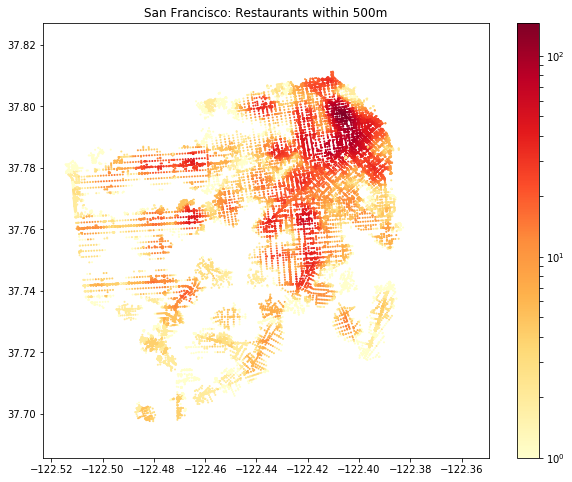

In [25]:
fig, ax = plt.subplots(figsize=(10,8))

plt.title('San Francisco: Restaurants within 500m')
plt.scatter(network.nodes_df.x, network.nodes_df.y, 
            c=accessibility, s=1, cmap='YlOrRd', 
            norm=matplotlib.colors.LogNorm())
cb = plt.colorbar()

plt.show()